# Prepare Data and Enivronment

Using DecisionTreeClassifier as the main model

In [1]:
#import the dataset from drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import

In [2]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.3 MB/s eta 0:00:00


In [3]:
import json
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from category_encoders import OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import VimeoVideo
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
def wrangle(filename):
  # Import and open the csv file
  df = pd.read_csv(filename)

  # Identify leaky columns
  #df.drop(columns = "cellphone_access", inplace = True)

  # Drop high cardinality
  #df.drop(columns = "uniqueid", inplace = True)


  return df

In [7]:
train_df = wrangle("/content/drive/MyDrive/Financial Inclusion in Africa/Train.csv")
print(train_df.shape)
train_df.head()

(23524, 13)


,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


## Explore

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [9]:
train_df.isnull().sum() / train_df.shape[0]

country                   0.0
year                      0.0
uniqueid                  0.0
bank_account              0.0
location_type             0.0
cellphone_access          0.0
household_size            0.0
age_of_respondent         0.0
gender_of_respondent      0.0
relationship_with_head    0.0
marital_status            0.0
education_level           0.0
job_type                  0.0
dtype: float64

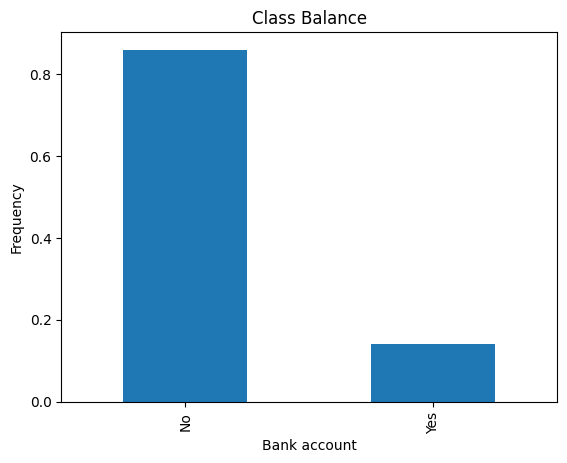

In [10]:
# Plot class Balance
train_df["bank_account"].value_counts(normalize = True).plot(
    kind = "bar",
    xlabel = "Bank account",
    ylabel = "Frequency",
    title = "Class Balance"
);

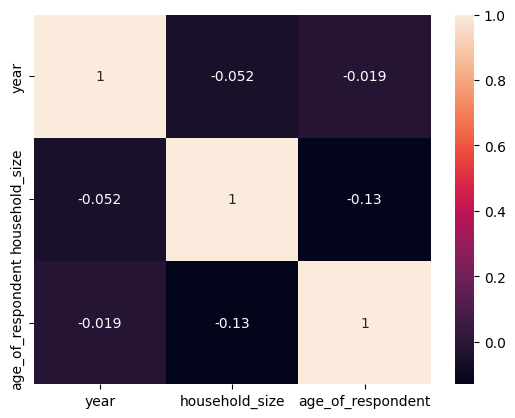

In [11]:
# Check for the column that greatly influence the target variable
corr = train_df.drop(columns = "bank_account").corr()
sns.heatmap(corr, annot = True);

**Explore columns with high muiltcolinearity**


> Multicolinearity means features that are highly correlated with each other



In [ ]:
# Multicolinearity means features that are highly correlated with each other
# To resolve the issue: the feature with the less predictive power on the target variable is eliminated
# df["severe_damage"].corr(df["count_floors_pre_eq"])

**Identify leaky columns**


> The feature "cellphone_access" has two main values and they directly predict the target variable

Hence, it has to be dropped from the dataset


In [ ]:
# The feature "cellphone_access" has two main values and they directly predict the target variable

**high-cardinality / redundant column**

In [ ]:
# The feature unique_id has high-cardinality

## Split

In [ ]:
# The vertical split
target = "bank_account"
X = train_df.drop(columns = target)
y = train_df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (23524, 11)
y shape: (23524,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18819, 11)
y_train shape: (18819,)
X_test shape: (4705, 11)
y_test shape: (4705,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

## Resample

**Perform undersampling using imbalanced-learn**

In [ ]:
under_sampler = RandomUnderSampler(random_state = 42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()

(4192, 11)


,country,year,uniqueid,location_type,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Rwanda,2016,uniqueid_2977,Rural,5,51,Female,Head of Household,Widowed,Primary education,Farming and Fishing
1,Rwanda,2016,uniqueid_673,Rural,2,72,Female,Head of Household,Married/Living together,No formal education,Government Dependent
2,Tanzania,2017,uniqueid_3125,Urban,1,45,Female,Head of Household,Married/Living together,Primary education,Self employed
3,Rwanda,2016,uniqueid_2529,Rural,7,38,Female,Spouse,Married/Living together,No formal education,Remittance Dependent
4,Rwanda,2016,uniqueid_2286,Rural,4,30,Female,Spouse,Married/Living together,Primary education,Farming and Fishing


**Perform oversampling using imbalanced-learn**

In [ ]:
over_sampler = RandomOverSampler(random_state = 42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()

(25918, 11)


,country,year,uniqueid,location_type,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Rwanda,2016,uniqueid_4854,Urban,4,39,Male,Head of Household,Married/Living together,Primary education,Other Income
1,Rwanda,2016,uniqueid_5689,Urban,5,17,Female,Child,Single/Never Married,Secondary education,Remittance Dependent
2,Tanzania,2017,uniqueid_193,Urban,1,57,Female,Head of Household,Married/Living together,Primary education,Self employed
3,Uganda,2018,uniqueid_1212,Urban,12,17,Female,Parent,Single/Never Married,Primary education,Self employed
4,Tanzania,2017,uniqueid_5593,Urban,2,30,Male,Head of Household,Single/Never Married,Secondary education,Informally employed


# Build Model

Three models will be built:


1.   the first to train on the normal split dataset
2.   the second to train on the undersampled dataset using imbalanced-learn
3.   the third to train on the oversampled dataset using imbalanced-learn




## Baseline

In [ ]:
# Baseline Accuracy

acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.8608


## Iterate

In [ ]:
# Fit on `X_train`, `y_train`
model_reg = make_pipeline(
    SimpleImputer(strategy = "most_frequent"), OrdinalEncoder(), MinMaxScaler(feature_range=(0, 1)), DecisionTreeClassifier(random_state = 42)
)
model_reg.fit(X_train, y_train)

# Fit on `X_train_under`, `y_train_under`
model_under = make_pipeline(
    SimpleImputer(strategy = "most_frequent"), OrdinalEncoder(), MinMaxScaler(feature_range=(0, 1)), DecisionTreeClassifier(random_state = 42)
)
model_under.fit(X_train_under, y_train_under)

# Fit on `X_train_over`, `y_train_over`
model_over = make_pipeline(
    SimpleImputer(strategy = "most_frequent"), OrdinalEncoder(), MinMaxScaler(feature_range=(0, 1)), DecisionTreeClassifier(random_state = 42)
)
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(cols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                mapping=[{'col': 0, 'data_type': dtype('O'),
                                          'mapping': Rwanda      1
Tanzania    2
Uganda      3
Kenya       4
NaN        -2
dtype: int64},
                                         {'col': 1, 'data_type': dtype('O'),
                                          'mapping': 2016.0    1
2017.0    2
2018.0    3
NaN      -2
dtype: int64},
                                         {'col': 2, 'data_type': dtype('O'),
                                          'm...
                                         {'col': 10, 'data_type': dtype('O'),
                                          'mapping': Other Income                     1
Remittance Dependent             2
Self employed                    3
Informally employed              4
No Income                        5
Farming and Fishing              6
Formally employed Government     7
Government Dependent             8
Formally employed Private        9
Dont Know/Refuse to answer      10
NaN                             -2
dtype: int64}])),
                ('minmaxscaler', MinMaxScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

**Re-iterate**

In [ ]:
depth_hyperparams = range(1, 20, 2)

In [ ]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = model = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth = d, random_state = 42)
    )
    # Fit model to training data
    test_model.fit(X_train_over, y_train_over)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train_over, y_train_over))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.6294081333436222, 0.6935720348792345, 0.7419168145690254]
Validation Accuracy Scores: [0.8607863974495218, 0.7489373007438895, 0.7627523910733263]


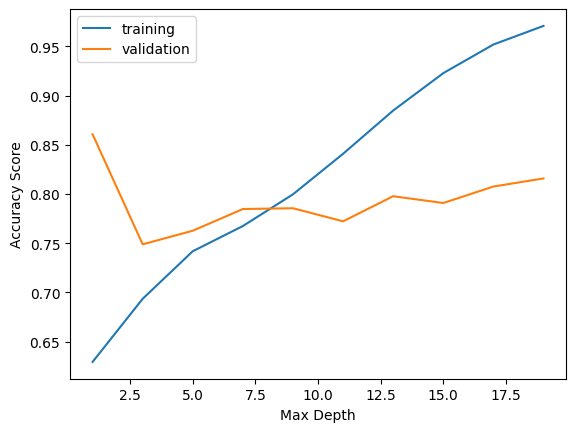

In [ ]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label = "training")
plt.plot(depth_hyperparams, validation_acc, label = "validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

In [ ]:
# Build Model
model_over_d = make_pipeline(
     SimpleImputer(strategy = "most_frequent"), OrdinalEncoder(), MinMaxScaler(feature_range=(0, 1)), DecisionTreeClassifier(max_depth = 8, random_state = 42)
)
# Fit model to training data
model_over_d.fit(X_train_over, y_train_over)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(cols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                mapping=[{'col': 0, 'data_type': dtype('O'),
                                          'mapping': Rwanda      1
Tanzania    2
Uganda      3
Kenya       4
NaN        -2
dtype: int64},
                                         {'col': 1, 'data_type': dtype('O'),
                                          'mapping': 2016.0    1
2017.0    2
2018.0    3
NaN      -2
dtype: int64},
                                         {'col': 2, 'data_type': dtype('O'),
                                          'm...
                                         {'col': 10, 'data_type': dtype('O'),
                                          'mapping': Other Income                     1
Remittance Dependent             2
Self employed                    3
Informally employed              4
No Income                        5
Farming and Fishing              6
Formally employed Government     7
Government Dependent             8
Formally employed Private        9
Dont Know/Refuse to answer      10
NaN                             -2
dtype: int64}])),
                ('minmaxscaler', MinMaxScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=42))])

## Evaluate

In [ ]:

for m in [model_reg, model_under, model_over]:
    acc_train = m.score(X_train, y_train)
    acc_test = m.score(X_test, y_test)

    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.7883
Training Accuracy: 0.8025
Test Accuracy: 0.6988
Training Accuracy: 1.0
Test Accuracy: 0.8232


In [ ]:
test_acc = model_over_d.score(X_test, y_test)
print("Test Accuracy:", round(test_acc, 4))

Test Accuracy: 0.7911


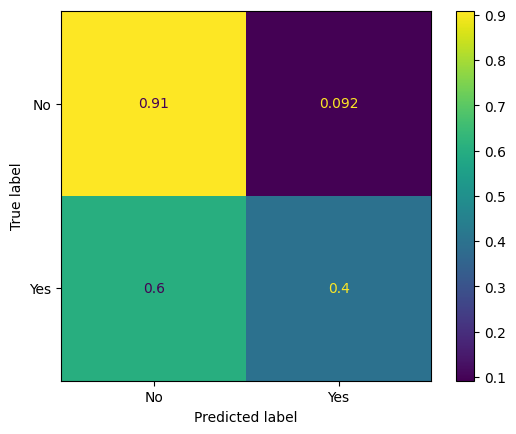

In [ ]:

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_reg, X_test, y_test, normalize='true');

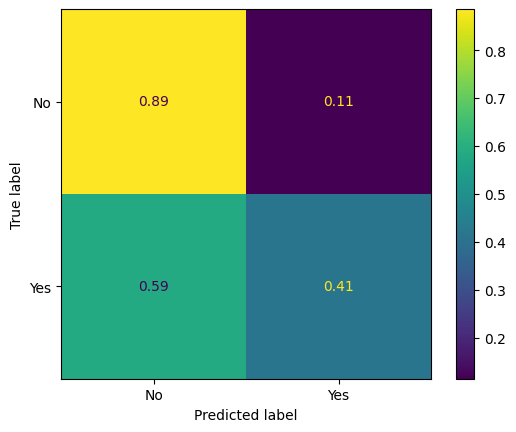

In [ ]:

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_over, X_test, y_test, normalize='true');

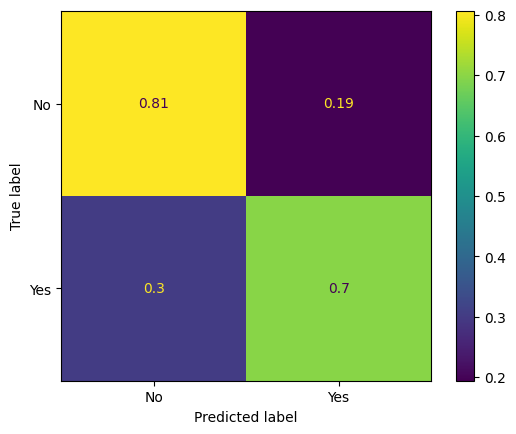

In [ ]:

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_over_d, X_test, y_test, normalize='true');

In [ ]:
# Deduce the depth of the model_over
depth = model_over_d.named_steps["decisiontreeclassifier"].get_depth()
print(depth)

8


# Communicate Result

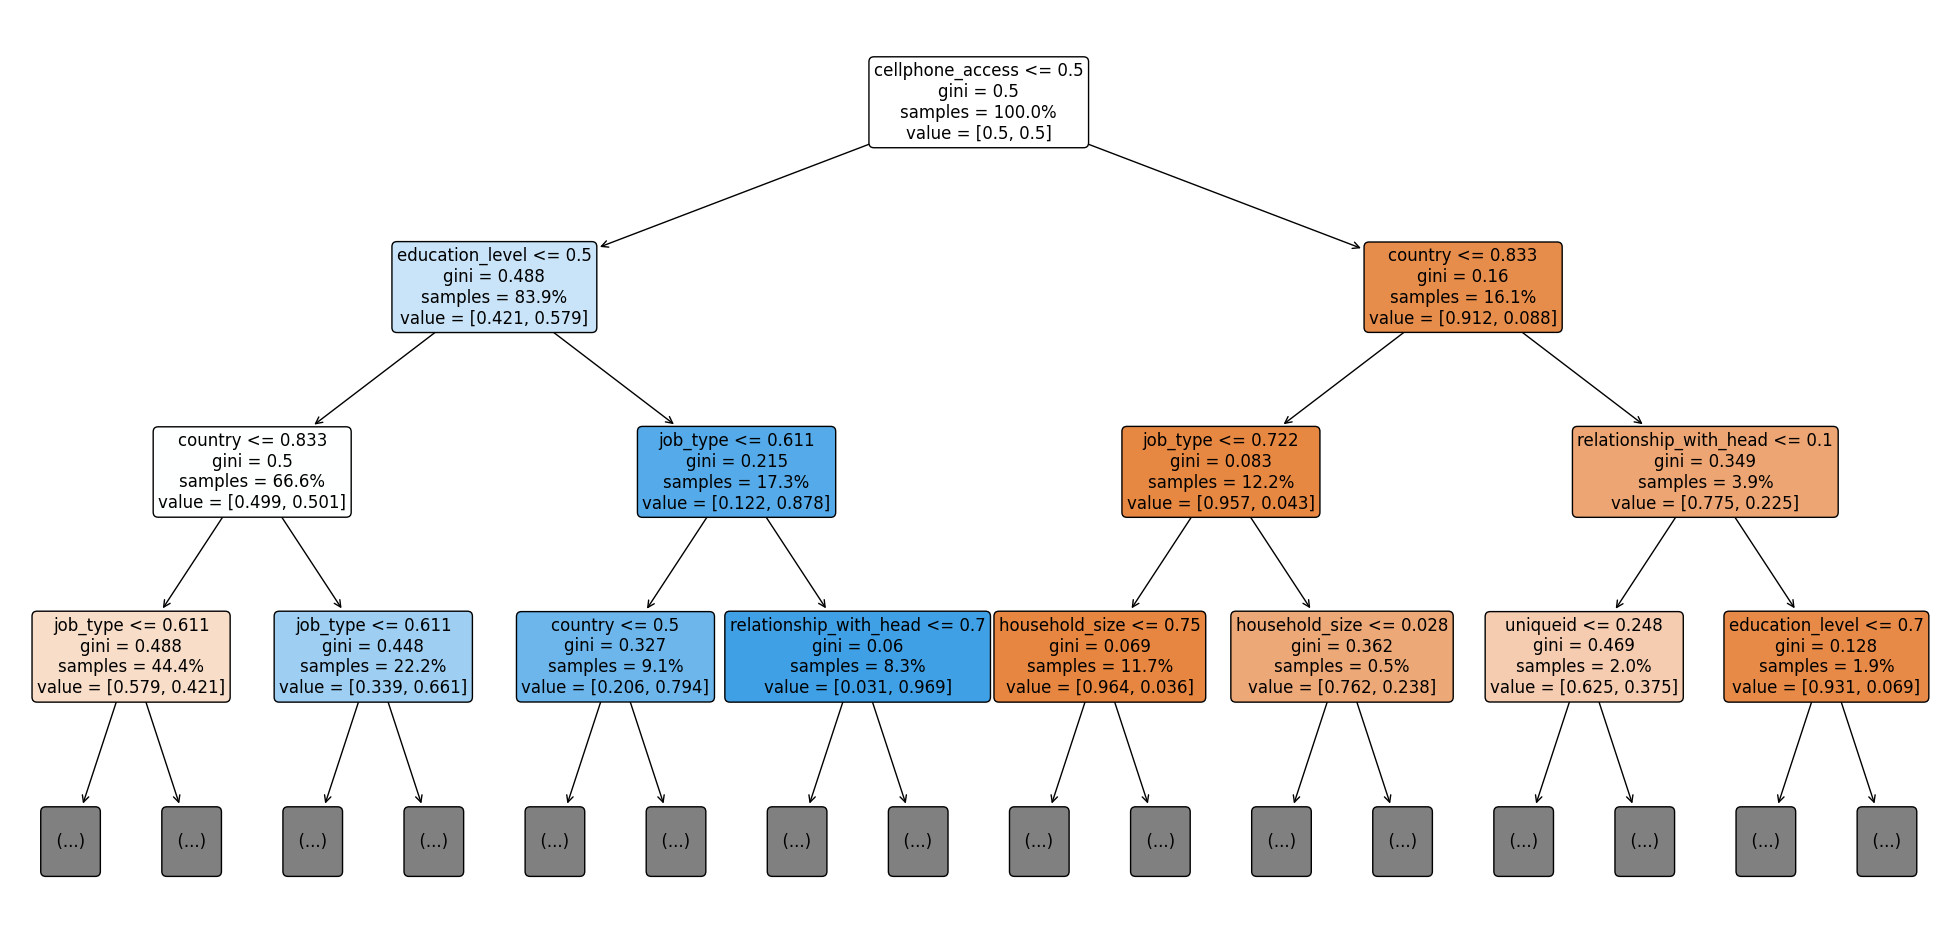

In [ ]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree = model_over.named_steps["decisiontreeclassifier"],
    feature_names = X_train_over.columns.to_list(),
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In [ ]:
len(importances)

10

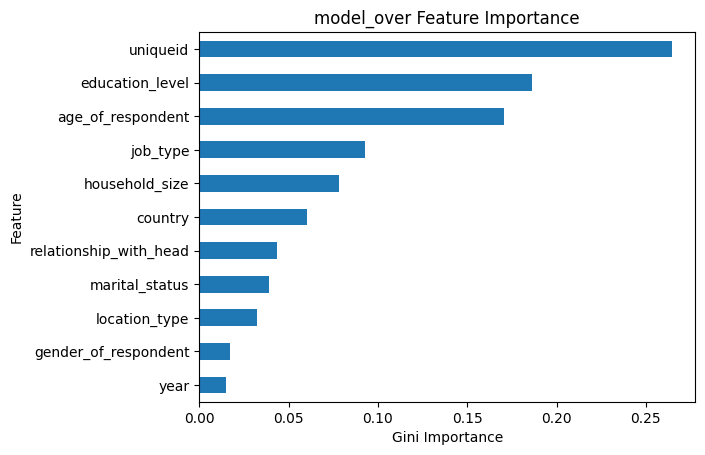

In [ ]:
# Get feature importance
# Get importances
importances = model_over.named_steps["decisiontreeclassifier"].feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances, index = X_train_over.columns).sort_values()

# Plot series
feat_imp.tail(15).plot(kind = "barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance");

## Model on test data

In [ ]:
# First save the two models. the model_reg, the model_over and model_over_d

# Save model
with open("/content/drive/MyDrive/Financial Inclusion in Africa/model_reg.pkl", "wb") as f:
    pickle.dump(model_reg, f)

In [ ]:
# Save model
with open("/content/drive/MyDrive/Financial Inclusion in Africa/model_over.pkl", "wb") as f:
    pickle.dump(model_over, f)

In [ ]:
# Save model
with open("/content/drive/MyDrive/Financial Inclusion in Africa/model_over_d.pkl", "wb") as f:
    pickle.dump(model_over_d, f)

## Make Predictions and submit files

In [ ]:
def make_predictions(data_filepath, submission_filepath, model_filepath, filename):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)

    # Import and open the csv file
    submission = pd.read_csv(submission_filepath)

    # Load model
    with open(model_filepath, "rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index = X_test.index, name = "bankrupt")

    # Create submission DataFrame
    submission = pd.DataFrame({"uniqueid": X_test["uniqueid"] + " x " + X_test["country"],
                           "bank_account": y_test_pred})

    # Create submission csv file csv file
    submission.to_csv(filename, index = False)
    return submission

In [ ]:
view_result = make_predictions(
    data_filepath="/content/drive/MyDrive/Financial Inclusion in Africa/Test.csv",
    submission_filepath = "/content/drive/MyDrive/Financial Inclusion in Africa/SampleSubmission.csv",
    model_filepath = "/content/drive/MyDrive/Financial Inclusion in Africa/model_over_d.pkl",
    filename = "/content/drive/MyDrive/Financial Inclusion in Africa/Third_Submission.csv"
)

# Submision File

In [ ]:
view_result.head()

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,Yes
1,uniqueid_6060 x Kenya,Yes
2,uniqueid_6065 x Kenya,No
3,uniqueid_6072 x Kenya,No
4,uniqueid_6073 x Kenya,No


In [ ]:
view_result.head()

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,Yes
1,uniqueid_6060 x Kenya,Yes
2,uniqueid_6065 x Kenya,No
3,uniqueid_6072 x Kenya,Yes
4,uniqueid_6073 x Kenya,No


In [ ]:
view_result.head()

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,Yes
1,uniqueid_6060 x Kenya,Yes
2,uniqueid_6065 x Kenya,No
3,uniqueid_6072 x Kenya,No
4,uniqueid_6073 x Kenya,No


In [ ]:
# Import and open the csv file
submission = pd.read_csv("/content/drive/MyDrive/Financial Inclusion in Africa/SampleSubmission.csv")
submission.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


In [ ]:
X_test = pd.read_csv("/content/drive/MyDrive/Financial Inclusion in Africa/Test.csv")

X_test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent
